In [1]:
import torch
from torchvision.transforms import functional

print(torch.cuda.is_available())

True


In [2]:
ckpt = torch.load("./ckpt/FFHQ_256.pt")

print(ckpt.keys())

dict_keys(['g', 'd', 'g_ema', 'g_optim', 'd_optim', 'args'])


In [3]:
# for k,v in ckpt["g_ema"].items():
#     print(k, ":", v.shape)

print(ckpt["args"])

Namespace(path='/mnt/blob/data/FFHQ_image256_70k_PIL', iter=1600000, batch=4, size=256, style_dim=512, r1=10.0, d_reg_every=16, ckpt='/mnt/blob/output/FFHQ_SPE_Alpha_1211/775000.pt', G_lr=1.1110888888704223e-05, D_lr=4.444355555481689e-05, beta1=0.0, beta2=0.99, start_dim=512, D_channel_multiplier=2, G_channel_multiplier=2, local_rank=0, print_freq=1000, save_freq=10000, eval_freq=25000, workers=8, checkpoint_path='//amltd912fca5b6da6f5df5f9744fe05a9f1e/projects/styleswin/amlt-results/7360211010.47197-be8d12e6-f118-43a0-886d-ae3968cd1035', sample_path='/tmp/samples', start_iter=775000, tf_log=False, gan_weight=1, val_num_batches=12500, val_batch_size=4, D_sn=True, ttur=True, eval=False, eval_iters=0, mlp_ratio=4, lr_mlp=0.01, bcr=True, bcr_fake_lambda=10, bcr_real_lambda=10, enable_full_resolution=8, auto_resume=False, lmdb=False, dataset_type='ffhq', use_checkpoint=True, use_flip=False, wandb=True, project_name='FFHQ256_BCR_ChannelM2_DoubleAttn_Alpha_Lrdecay_Continue', lr_decay=True, 

In [3]:
import os
os.add_dll_directory("C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v11.7\\bin")

from models.generator import *

# FFHQ 256
# G = Generator(256,512,8).to("cuda")
# FFHQ 1024
# G = Generator(1024,512,8,channel_multiplier=1).to("cuda")

G = Generator(256,512,8).to("cuda")
G.load_state_dict(ckpt["g_ema"])

C:\Users\PublicF\anaconda3\envs\stylegan3\lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<All keys matched successfully>

In [4]:
features = []
with torch.no_grad():
    gen = torch.Generator()
    gen = gen.manual_seed(1896)
    
    noise = torch.randn(1,512, generator=gen).to("cuda")
    
    image, latent, feature = G(noise, return_latents=True, return_features=True)
    features.append(feature)

### Wrong RGB

if dircetly call to_pil_image(image), it can cause wrong rgb

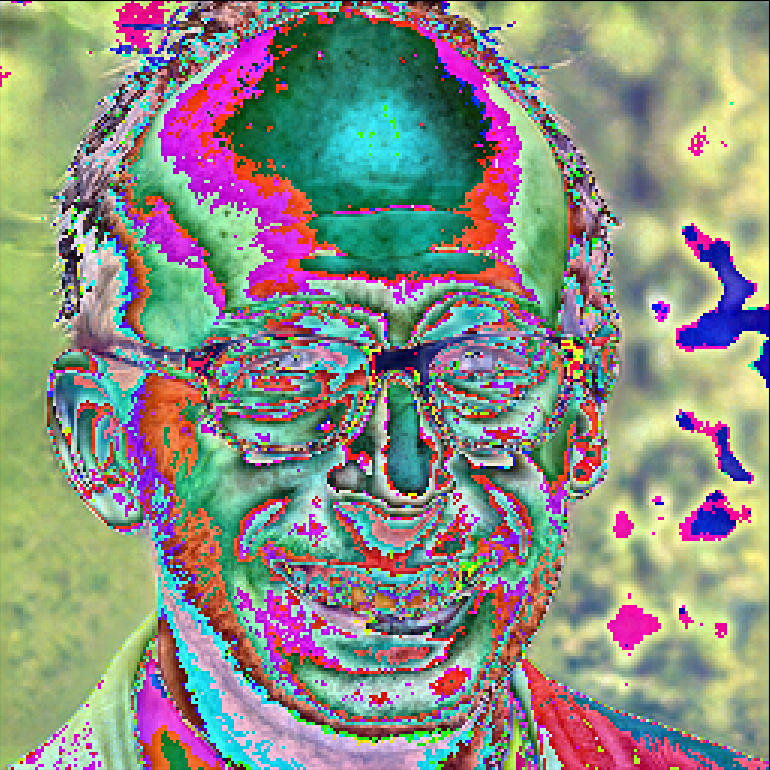

the solution is from the answer of this stackoverflow post:
https://stackoverflow.com/questions/47318871/valueerror-floating-point-image-rgb-values-must-be-in-the-0-1-range-while-usi

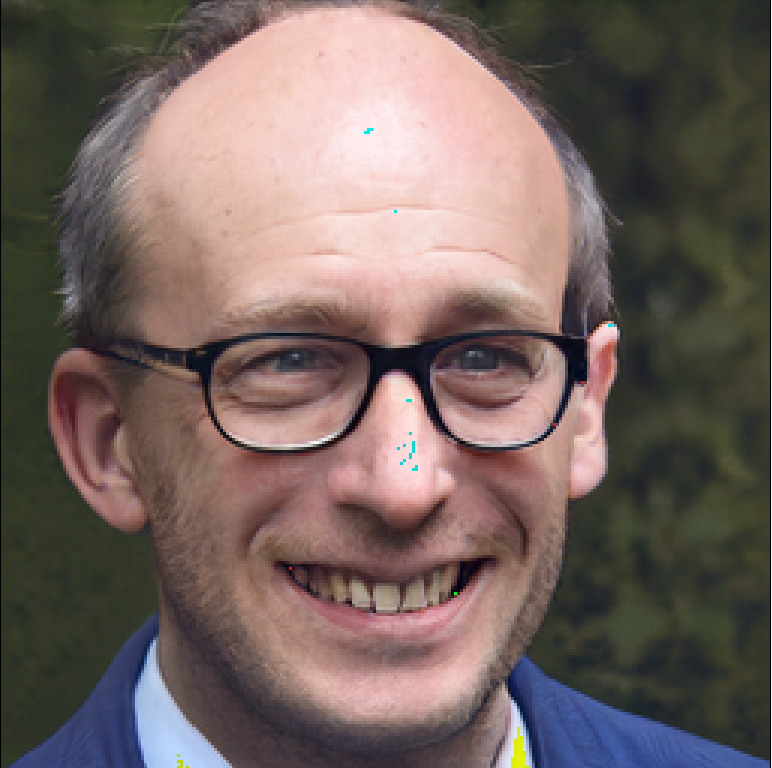

we can see there's still something wrong, so i change 2.25 to around 2.8

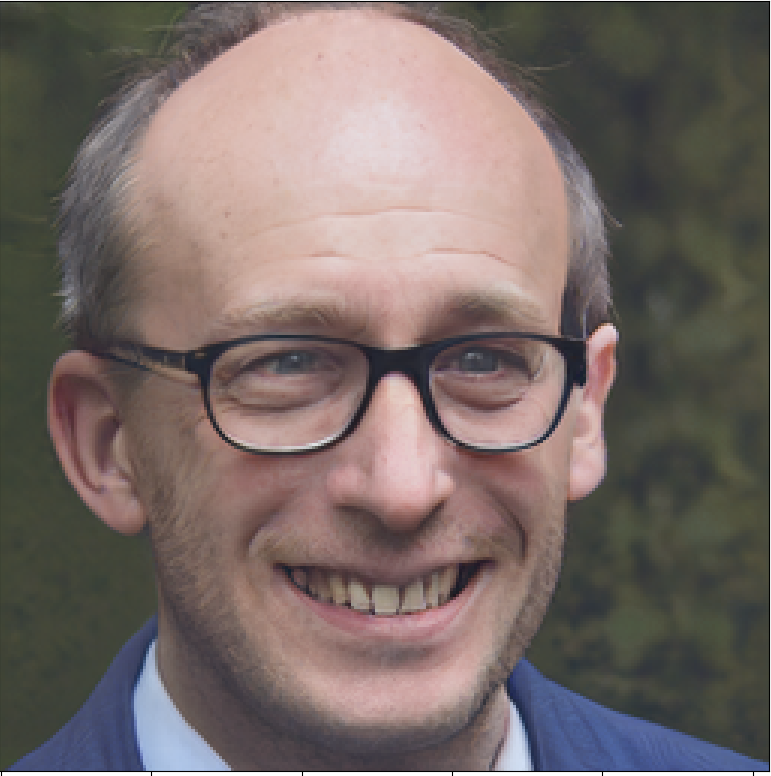

and solve the problems

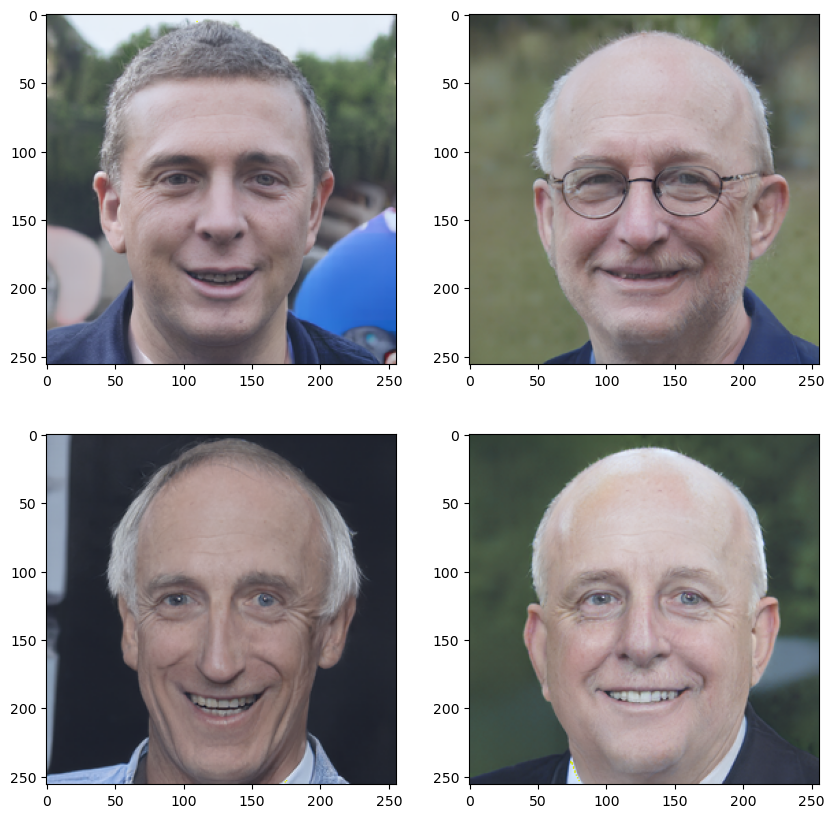

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

for i in range(2):
    for j in range(2):
        img = (1/(2*2.8)) * image[2*i+j].permute(1,2,0).cpu().numpy() + 0.5
        img = functional.to_pil_image(img , mode="RGB")
        plt.subplot(2,2,2*i+j+1)
        plt.imshow(img)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
img = (1/(2*2.8)) * image[0].permute(1,2,0).cpu().numpy() + 0.5
img = functional.to_pil_image(img , mode="RGB")

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

# Generate heatmap from features

reference: https://ravivaishnav20.medium.com/visualizing-feature-maps-using-pytorch-12a48cd1e573

8
torch.Size([8, 8])
torch.Size([16, 16])
torch.Size([32, 32])
torch.Size([32, 32])
torch.Size([64, 64])
torch.Size([128, 128])
torch.Size([128, 128])
torch.Size([256, 256])
torch.Size([256, 256])
0.1594259 -0.17760354 0.3638382 -0.49111357


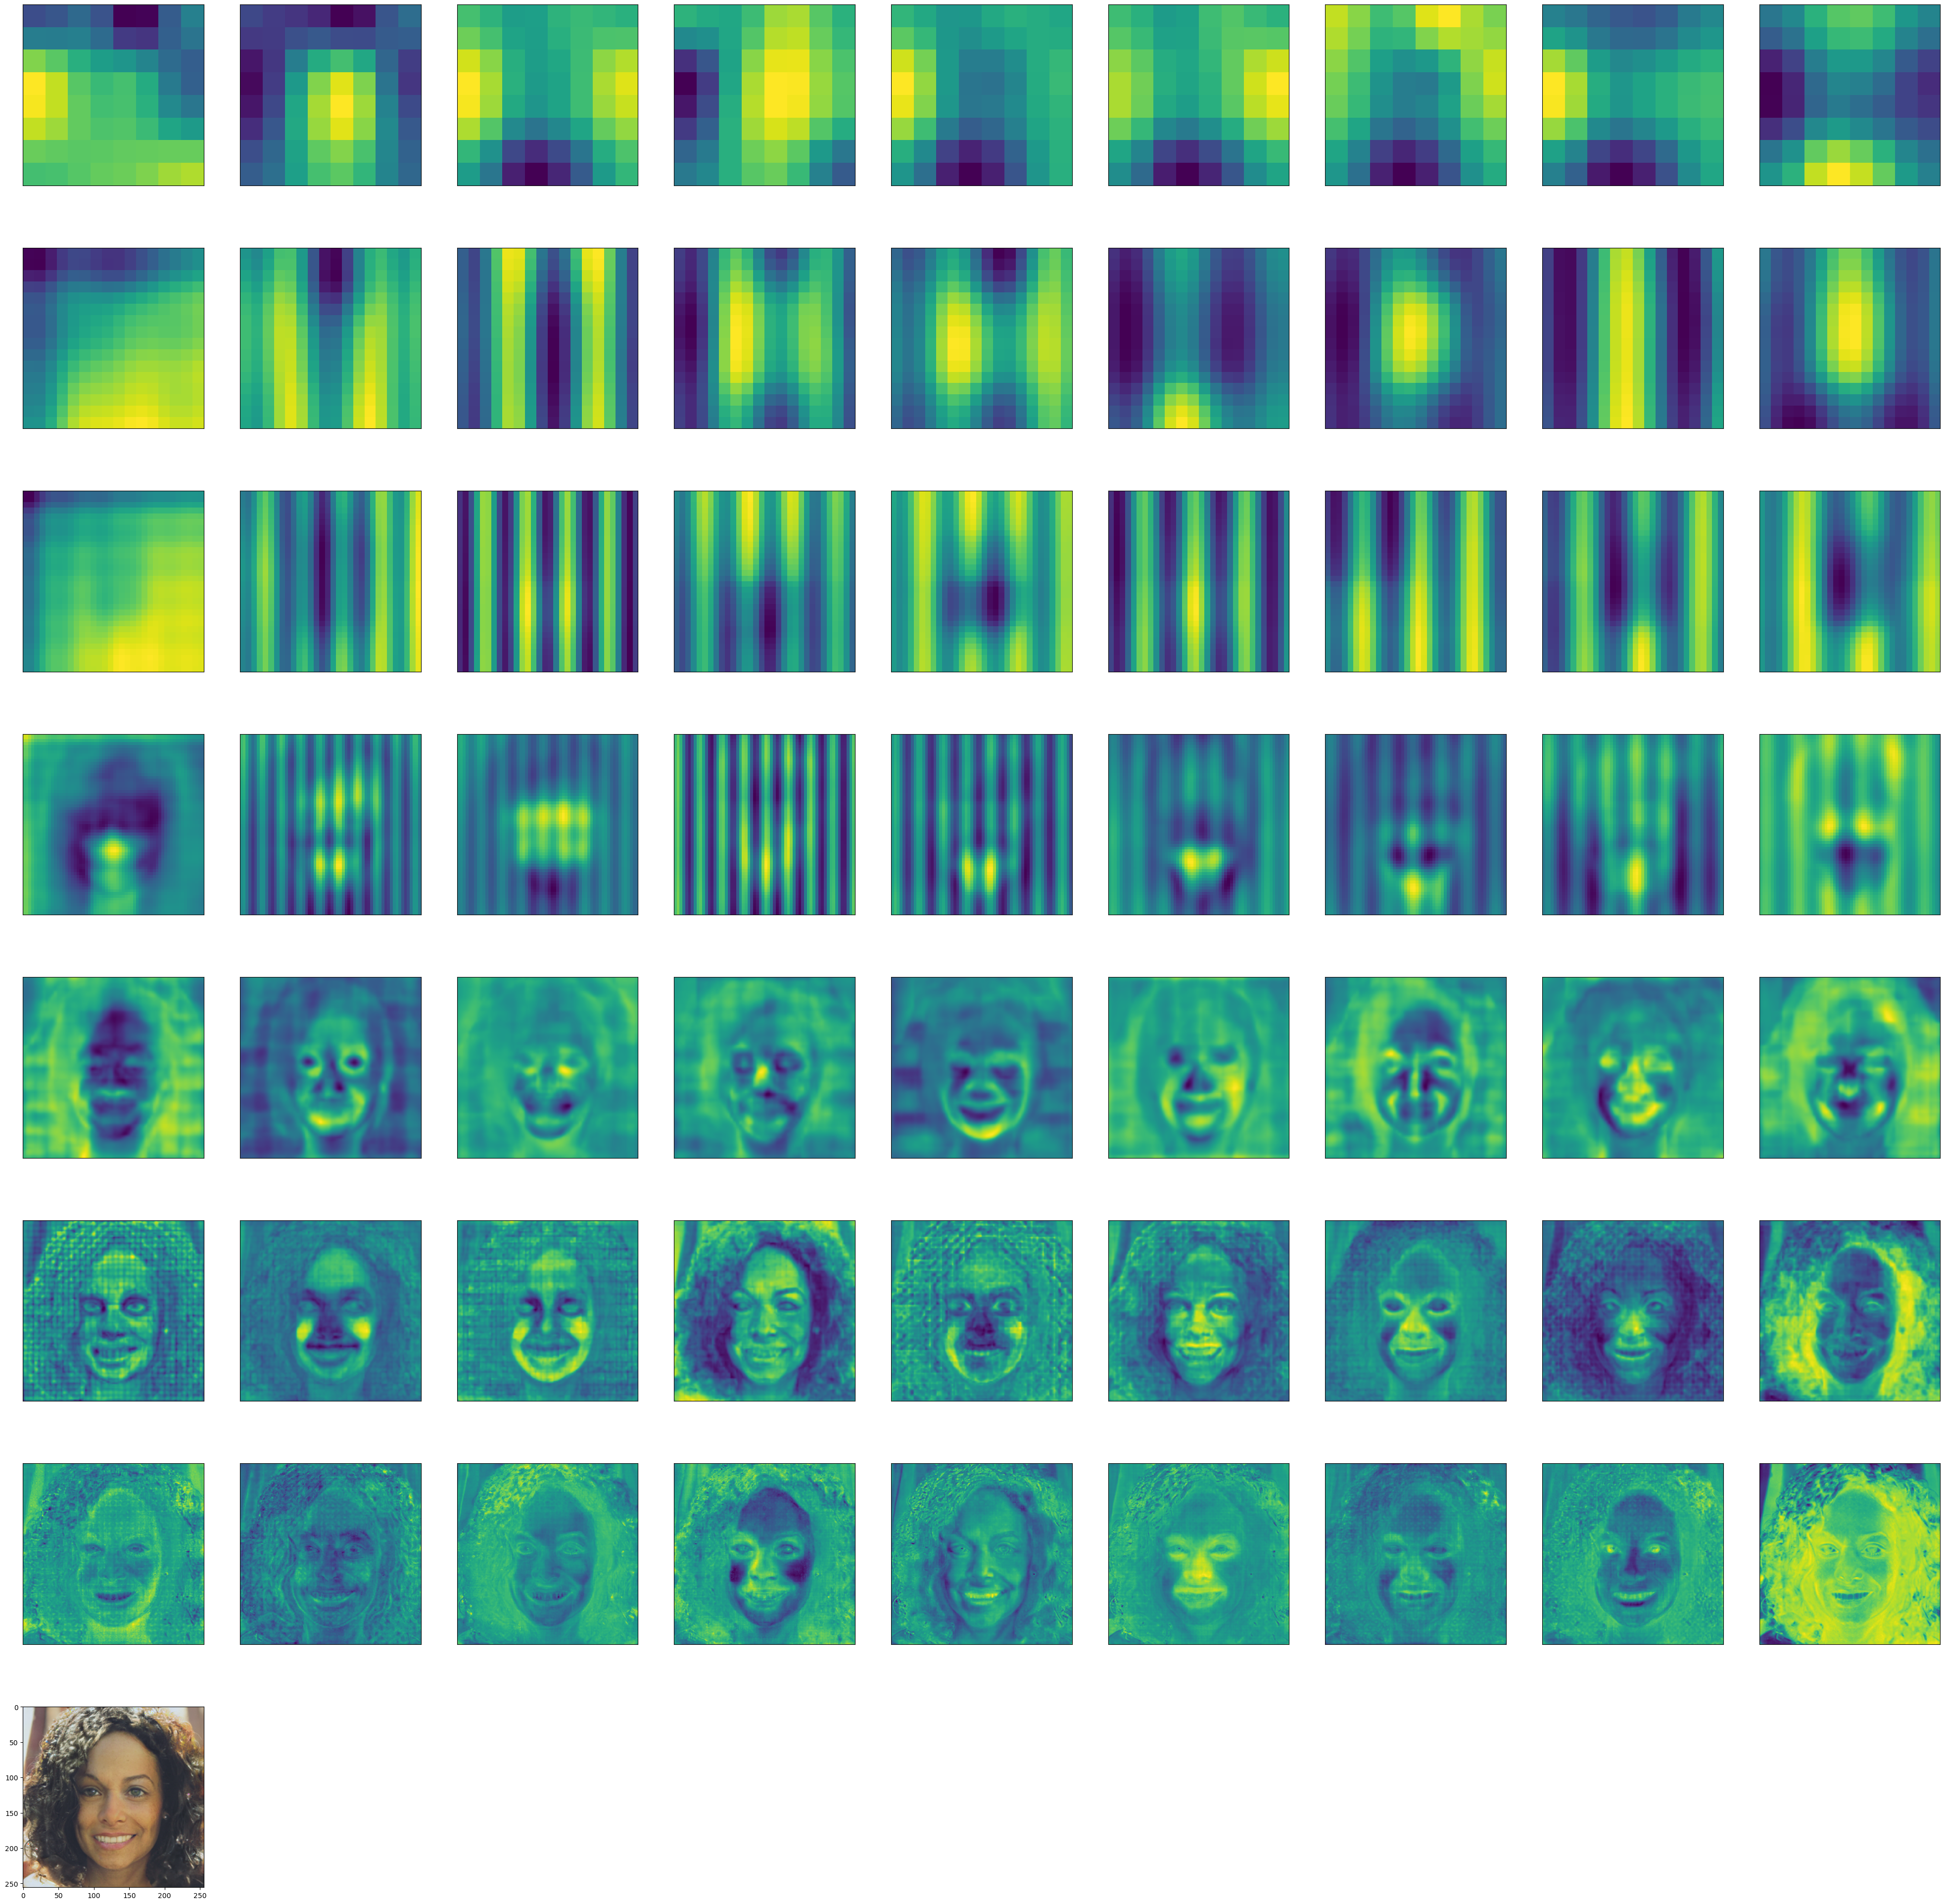

In [81]:
import matplotlib.pyplot as plt
import math

plt.figure(figsize=(50,50))
print(len(features[0]))
# print(features)

for i in range(3):
    for j in range(3):
        # print("b4:", features[0][2*i+j].shape)
        d = features[0][2*i+j+1].size(dim=1)
        d2 = features[0][2*i+j+1].size(dim=2)
        feature = features[0][2*i+j+1].transpose(-1,-2).reshape(1, d2, int(math.sqrt(d)), int(math.sqrt(d)))
        # print("af:",feature.shape)

        img = feature[0]
        # this sum function should change
        # img = torch.sum(img, 0)

        for k in range(1,9):
            plt.subplot(8,9,9*(2*i+j)+k+1)
            ax = plt.gca()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            plt.imshow(img[k].cpu().numpy())
            # print(9*(2*i+j)+k+1)
        img = torch.sum(img, 0)
        
        img = img / feature[0].shape[0]
        print(img.shape)
        # plt.subplot(2,4,(2*i+j)+1)
        plt.subplot(8,9,9*(2*i+j)+1)
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(img.cpu().numpy())
        if 2*i+j == 5:
            sixthlayer = img.cpu().numpy()
        if 2*i+j == 6:
            seventhlayer = img.cpu().numpy()


print(sixthlayer.max(),sixthlayer.min(),seventhlayer.max(),seventhlayer.min())

plt.subplot(8,9,64)
# plt.subplot(2,4,8)
img = (1/(2*2.8)) * image[0].permute(1,2,0).cpu().numpy() + 0.5
img = functional.to_pil_image(img , mode="RGB")
plt.imshow(img)
plt.show()

120 150 118 122 148 152
90 150 88 92 148 152


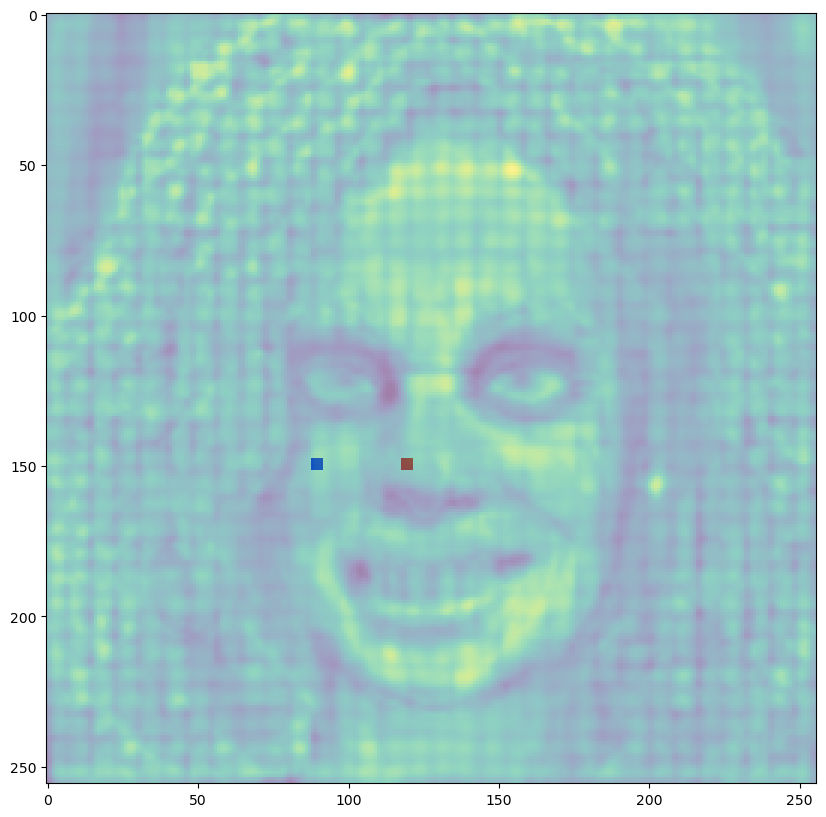

In [82]:
from array import array

plt.figure(figsize=(10,10))

insert_order = [np.array([120, 150]), np.array([90, 150])]

points =[]

color = [(1,0,0),(0,0,1)]

im_w, im_h = 256, 256
rgb_channel = 3
rgba_channel = 4
radius = 2

raw_data = array('f', [1] * im_w * im_h * rgba_channel)

for j, i in enumerate(insert_order):
    points.append(i)
    x, y = i[0], i[1]
    x_start, x_end = max(0, x - radius), min(im_w, x + radius)
    y_start, y_end = max(0, y - radius), min(im_h, y + radius)
    print(x, y, x_start, x_end, y_start, y_end)
    for x in range(x_start, x_end):
        for y in range(y_start, y_end):
            offset = (y * im_w + x) * rgba_channel
            raw_data[offset:offset + rgb_channel] = array('f', color[j%2][:rgb_channel])


plt.imshow(sixthlayer, alpha=1)
# plt.imshow(seventhlayer, alpha=1)
plt.imshow(np.asarray(raw_data).reshape(256,256,4), alpha=0.5)

120 150 56 184 86 214
1.0 0.0 1.0 0.0


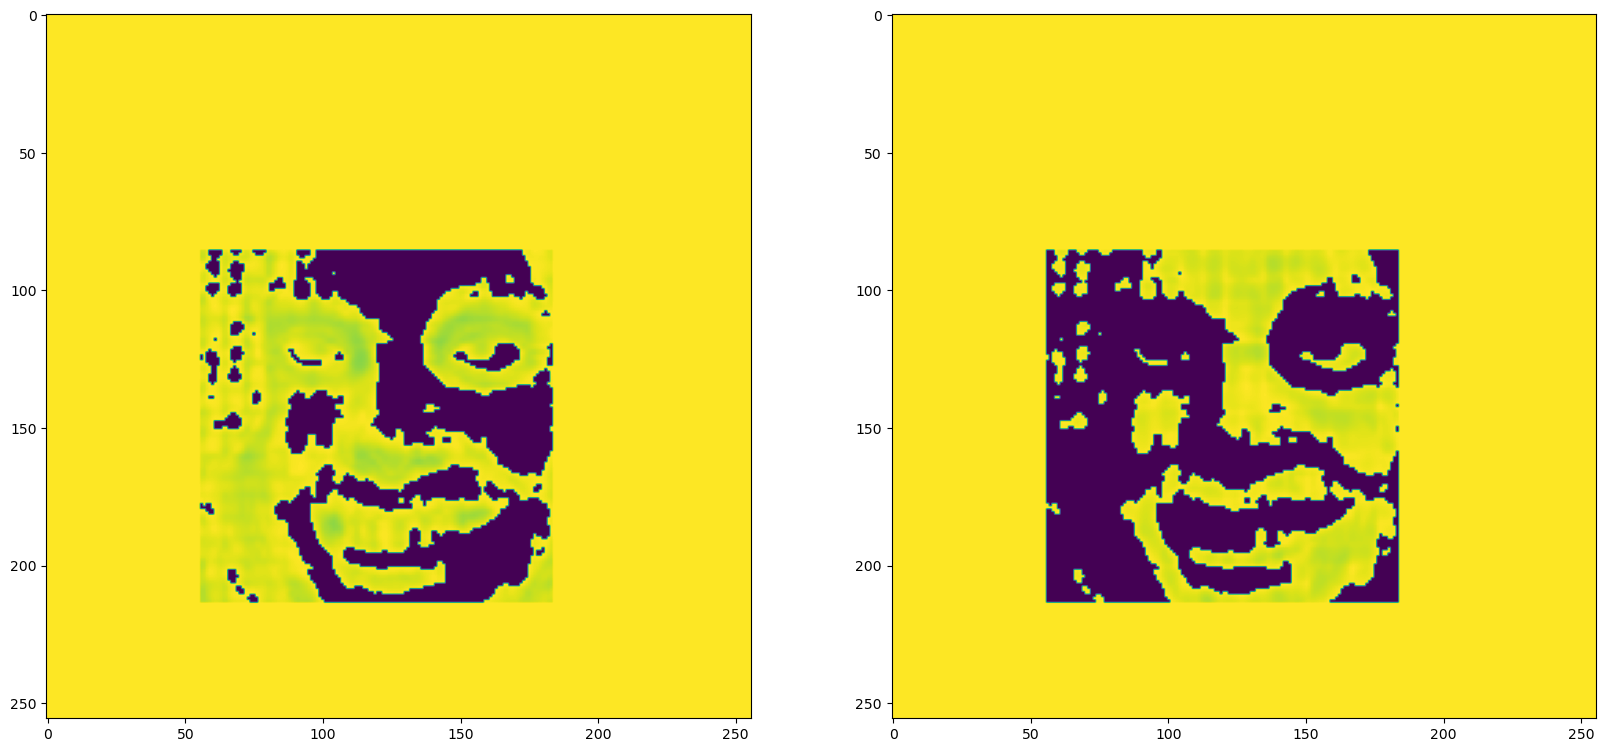

In [52]:
mask_upper_six = np.ones([256,256], np.float32)
mask_lower_six = np.ones([256,256], np.float32)

# suppose there's two layer: upper and lower
# and we let user to choose which layer to select
# in down below let user select upper

upper = 1
lower = 0

selection = upper

im_w, im_h = 256, 256
mask_area = 64

for p in range(len(points)):
    # only select start points
    if p % 2 == 1: continue
   
    x = points[p][0]
    y = points[p][1]
    x_start, x_end = max(0, x - mask_area), min(im_w, x + mask_area)
    y_start, y_end = max(0, y - mask_area), min(im_h, y + mask_area)
    print(x,y,x_start,x_end,y_start,y_end)
    for x in range(x_start, x_end):
        for y in range(y_start, y_end):
                # if sixthlayer[y,x] > 0:
                #     mask_upper_six[y,x] = 0
                # else:
                #     mask_lower_six[y,x] = 0;
                if sixthlayer[y,x] < 0:
                    mask_upper_six[y,x] = 0
                    mask_lower_six[y,x] = sixthlayer[y,x] + 1
                else:
                    mask_upper_six[y,x] = 1 - sixthlayer[y,x]
                    mask_lower_six[y,x] = 0
                    
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(mask_lower_six)
plt.subplot(1,2,2)
plt.imshow(mask_upper_six)

print(mask_upper_six.max(),mask_upper_six.min(),mask_lower_six.max(),mask_lower_six.min())

In [97]:
count = [0,0]

for i in range(im_w):
    for j in range(im_h):
        p = sixthlayer[j,i] 
        if p < 0 and p > -1:
            count[0]+=1
        elif p > 0 and p < 1:
            count[1]+=1
        else:
            print(p)

print(count)

[42322, 23214]


120 150 56 184 86 214
1.0 0.0 1.0 0.0


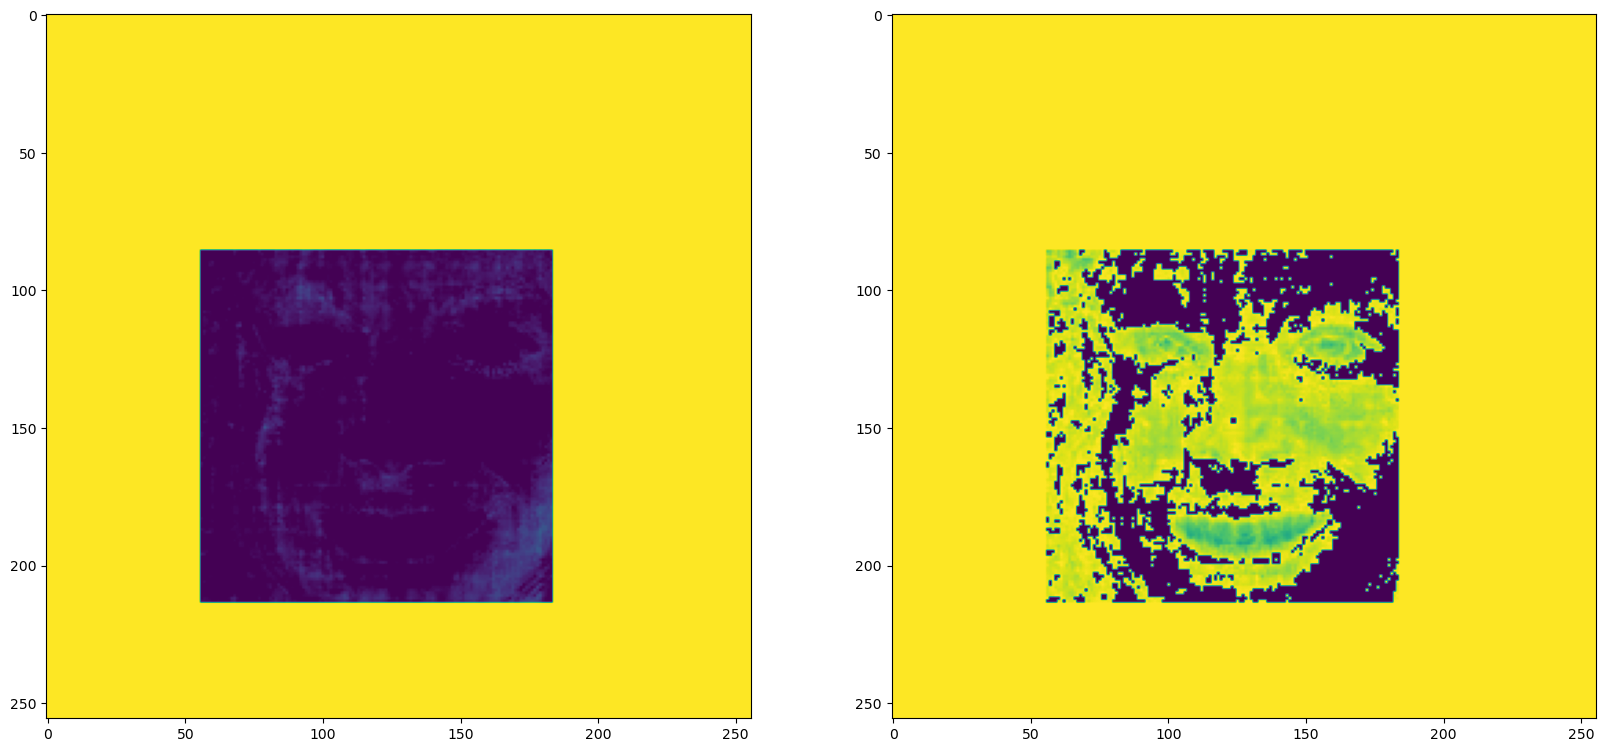

In [48]:
mask_upper_sev = np.ones([256,256], np.float32)
mask_lower_sev = np.ones([256,256], np.float32)

upper = 1
lower = 0

selection = upper

im_w, im_h = 256, 256
mask_area = 64

for p in range(len(points)):
    # only select start points
    if p % 2 == 1: continue
   
    x = points[p][0]
    y = points[p][1]
    x_start, x_end = max(0, x - mask_area), min(im_w, x + mask_area)
    y_start, y_end = max(0, y - mask_area), min(im_h, y + mask_area)
    print(x,y,x_start,x_end,y_start,y_end)
    for x in range(x_start, x_end):
        for y in range(y_start, y_end):
                # if seventhlayer[y,x] > 0:
                #     mask_upper_sev[y,x] = 0
                # else:
                #     mask_lower_sev[y,x] = 0;
                if seventhlayer[y,x] < 0:
                    mask_upper_sev[y,x] = 0
                    mask_lower_sev[y,x] = seventhlayer[y,x] + 1
                else:
                    mask_upper_sev[y,x] = seventhlayer[y,x]
                    mask_lower_sev[y,x] = 0

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(mask_upper_sev)
plt.subplot(1,2,2)
plt.imshow(mask_lower_sev)

print(mask_upper_sev.max(),mask_upper_sev.min(),mask_lower_sev.max(),mask_lower_sev.min())

148.0 105.0


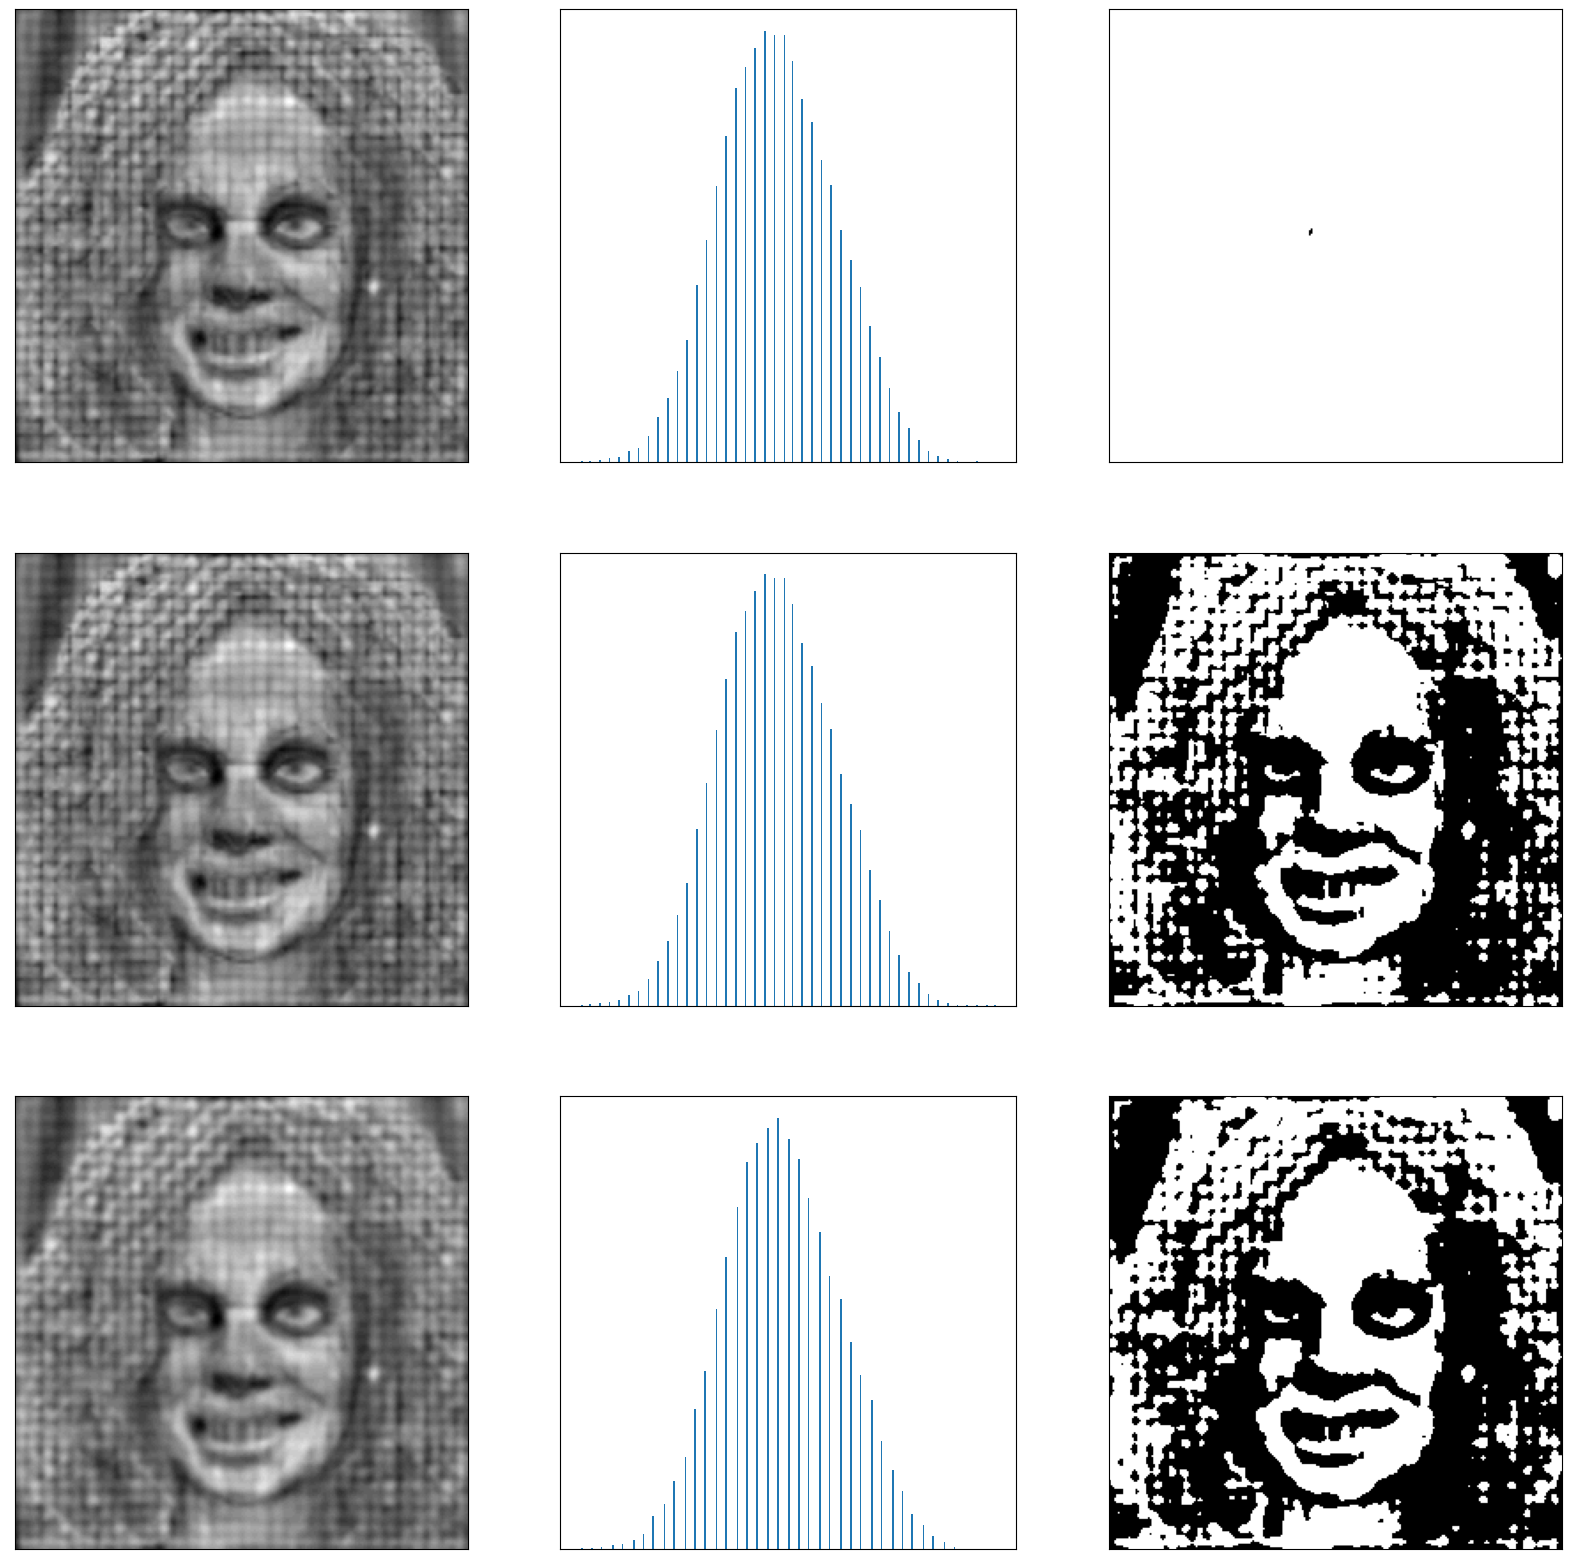

In [88]:
import cv2

plt.figure(figsize=(20,20))

im_w, im_h = 256, 256

temp_six = np.zeros((im_w, im_h))

for i in range(im_h):
    for j in range(im_w):
        temp_six[i,j] = round((((sixthlayer[i,j]+1) / 2) * 255), 0)

print(temp_six.max(), temp_six.min())
temp_six = temp_six.astype('uint8')

# global thresholding
ret1, thres1 = cv2.threshold(temp_six, temp_six.min(), temp_six.max(), cv2.THRESH_BINARY)
# ostu thresholding
ret2, thres2 = cv2.threshold(temp_six, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# blur and thresholding
blur = cv2.GaussianBlur(temp_six,(5,5),0)
ret3, thres3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

images = [temp_six, 0, thres1,
          temp_six, 0 , thres2,
          blur, 0, thres3]

for i in range(3):
    plt.subplot(3,3,3*i+1)
    plt.imshow(images[3*i], 'gray')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(3,3,3*i+2)
    plt.hist(images[3*i].ravel(), 256)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(3,3,3*i+3)
    plt.imshow(images[3*i+2], 'gray')
    plt.xticks([])
    plt.yticks([])
plt.show()

In [89]:
for i in range(255):
    for j in range(255):
        if thres3[i,j] == 255:
            thres3[i,j] = 1:

[[  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
